# **NN & NNLP**

## **LSTM for Text Classification**

<br>

Trained word embeddings by casting the unsupervised learning problem as a binary classification problem (in the skip-gram model). This notebook shows building an LSTM model to classify movie reviews as either positive or negative. After training, will extract the word embeddings learned by the model.



### **0. Prepare the environment**

Open Google Colab or activate the virtual environment you’ve created

### **1. Getting the Dataset**
This is a dataset of 25,000 movie reviews from IMDB, labeled by sentiment - positive (1) or negative (0).
<br>

The reviews have been preprocessed, and each review is encoded as a list of word indices. In skip-gram model, we assigned the indices to the word randomly (or in order of their first appearance in the corpus) but in this preprocessed corpus, the words are indexed by overall frequency in the dataset, such that a word with index 3 occurs more frequently than a word with index 10.
<br>

In the following blocks of code in this section, we will load and visualize the data.


In [ ]:
from tensorflow.keras import datasets

imdb = datasets.imdb

In [ ]:
%%capture

# we'll use the most frequent 10000 words in the vocabulary
VOCAB_SIZE = 10000

# 0 is reserved for ‘<PAD>’, 1 for ‘<START>’ and 2 for ‘<UNK>’ i.e. words not in vocabulary
# the documentation says index_from = 3 but actually uses the value as an offset. The words
# in the dictionary are indexed from 1 by default so, saying index_from=3 means any actual
# words would start from 4 (1+3) and index 3 will be left unused. We use index_from=offset=2 to avoid this
# If you want to explore this further, you may look up the source_code for load_data here
# https://github.com/tensorflow/tensorflow/blob/v2.4.1/tensorflow/python/keras/datasets/imdb.py#L31-L162
OFFSET = 2

# for more information on the load_data method, type(help(load_data))
(train_data,train_labels),(test_data,test_labels) = imdb.load_data(num_words=VOCAB_SIZE, index_from=OFFSET)

***Sanity Check***

Each instance in the training data is a list of word indices representing the words in a movie review.

Each label is 1 if that review is positive, else 0.

In [ ]:
print('Sample review:', train_data[0])

Sample review: [1, 13, 21, 15, 42, 529, 972, 1621, 1384, 64, 457, 4467, 65, 3940, 3, 172, 35, 255, 4, 24, 99, 42, 837, 111, 49, 669, 2, 8, 34, 479, 283, 4, 149, 3, 171, 111, 166, 2, 335, 384, 38, 3, 171, 4535, 1110, 16, 545, 37, 12, 446, 3, 191, 49, 15, 5, 146, 2024, 18, 13, 21, 3, 1919, 4612, 468, 3, 21, 70, 86, 11, 15, 42, 529, 37, 75, 14, 12, 1246, 3, 21, 16, 514, 16, 11, 15, 625, 17, 2, 4, 61, 385, 11, 7, 315, 7, 105, 4, 3, 2222, 5243, 15, 479, 65, 3784, 32, 3, 129, 11, 15, 37, 618, 4, 24, 123, 50, 35, 134, 47, 24, 1414, 32, 5, 21, 11, 214, 27, 76, 51, 4, 13, 406, 15, 81, 2, 7, 3, 106, 116, 5951, 14, 255, 3, 2, 6, 3765, 4, 722, 35, 70, 42, 529, 475, 25, 399, 316, 45, 6, 3, 2, 1028, 12, 103, 87, 3, 380, 14, 296, 97, 31, 2070, 55, 25, 140, 5, 193, 7485, 17, 3, 225, 21, 20, 133, 475, 25, 479, 4, 143, 29, 5534, 17, 50, 35, 27, 223, 91, 24, 103, 3, 225, 64, 15, 37, 1333, 87, 11, 15, 282, 4, 15, 4471, 112, 102, 31, 14, 15, 5344, 18, 177, 31]


In [ ]:
print('\n Sample label:', train_labels[0])


 Sample label: 1


### **2. Readying the Inputs for the LSTM**

The movie reviews are of different lengths. The standard way of dealing with varying length inputs is to ***pad*** or ***truncate*** each sentence to a fixed length (which we choose heuristically).

Keras provides a way to do this.  In this section, you will use the keras.preprocessing.sequence method <pad_sequences> handle padding and truncating.

**Hints**

*  help(pad_sequences) will give you more information about how this works.
*  You can experiment with 'pre' vs 'post' padding/truncating. In practice, 'pre' padding is more effective for our purposes; can you hypothesize about why this is?
*  Since we have reserved 0 for \<PAD\>, your pad value should be set to 0.
*  The maximum length has been specified below as MAX_LENGTH.

In [ ]:
# from keras.preprocessing.sequence import pad_sequences
# from tensorflow.keras.preprocessing.sequence import pad_sequences
# from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import pad_sequences


MAX_LENGHT = 500

# YOUR CODE GOES HERE
padded_train_data = pad_sequences(train_data, padding="pre",
                                  maxlen=MAX_LENGHT,
                                  truncating="pre",
                                  value=0.0)
padded_test_data = pad_sequences(test_data,
                                 padding="pre",
                                 maxlen=MAX_LENGHT,
                                 truncating="pre",
                                 value=0.0)

***Sanity Check***

For the first training example, print its length and the padded sequence to see the effect of your padding process.

PS: Pre-padding was used for the output you see below.

In [ ]:
print('Length of sample train_data before preprocessing:', len(train_data[0]))
print('Length of sample train_data after preprocessing:', len(padded_train_data[0]))
print('Sample train data:', padded_train_data[0])

Length of sample train_data before preprocessing: 218
Length of sample train_data after preprocessing: 500
Sample train data: [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0  

### **3. Building the Model**

In this section, you will use the keras Model API to build a classification model.

*   The first step is to tell the model what sort of input to expect using the keras \<Input\> layer
*   The second step is to add an embedding layer like we did last week.
This embedding layer creates a lookup table of the form {word:embedding} for each of the unique words in our corpus. Use EMBED_SIZE = 100 (i.e each word is represented by a 100D vector such that each movie review is 500 X 100 in dimension.  Don't forget to set mask_zero=True since we are using 0 index as out padding.
*  The third step is to add an LSTM with 100 units. By leaving 'return_sequences' as False, the output of this model will be the output of the final time step of the LSTM. https://keras.io/api/layers/recurrent_layers/lstm/
*  The final layer of the model is a fully connected (Dense) layer. Can you figure out what activation function would be appropriate for this layer given the binary nature of the task?
*  The model should be compiled with a 'binary_crossentropy' loss function, an 'adam' optimizer. We also want to visualize the model accuracy during training so the 'metrics' parameter of the compile method should be set to ['accuracy'].

In [ ]:
from keras.layers import Input, Embedding, Dense, LSTM
from keras.models import Model

EMBED_SIZE = 100
# YOUR CODE GOES HERE
# Define an input layer that takes input of shape (500,)
imdb_input = Input(shape=(500,))

# Create an embedding layer that maps each word to a dense vector of dimension EMBED_SIZE
embedding_layer = Embedding(input_dim=VOCAB_SIZE,  # The size of the vocabulary
                            input_length=MAX_LENGHT,  # The maximum length of the input sequence
                            output_dim=EMBED_SIZE,  # The dimensionality of the embedding vector
                            embeddings_initializer="glorot_uniform",  # Initialization method for the weights
                            mask_zero=True)(imdb_input)  # Mask out zero-padding in input sequences

# Add an LSTM layer to the model to capture the temporal dependencies in the input sequence
lstm_layer = LSTM(EMBED_SIZE, return_sequences=False)(embedding_layer)

# Add a dense layer with a sigmoid activation function to generate the binary classification output
dense_layer = Dense(1, activation='sigmoid')(lstm_layer)

# Create a model with the input and output layers
model = Model(inputs=imdb_input, outputs=dense_layer)

# Compile the model with Adam optimizer and binary cross-entropy loss function
model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])


***Sanity Check***

Print the model summary and visualize it using vis_utils.

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 500)]             0         
                                                                 
 embedding (Embedding)       (None, 500, 100)          1000000   
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 1,080,501
Trainable params: 1,080,501
Non-trainable params: 0
_________________________________________________________________


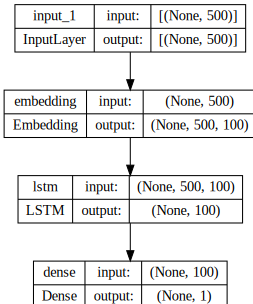

In [ ]:
from IPython.display import SVG
from keras.utils import vis_utils
SVG(vis_utils.model_to_dot(model, show_shapes=True, show_layer_names=True, dpi=70).create(prog='dot', format='svg'))


### **4. Training the Model**

A model can memorize the training data (this is called 'overfitting' and when it does so, it's training accuracy can continue to go up but it's accuracy on previously unseen (i.e. non-training) examples can be very poor. To ensure that this doesn't happen, researchers often intermittently check the performance of a model being trained on a held back dataset called the ***validation dataset***. This way, 'early stopping' or 'random search' can be used to select the model that will generalize best to unseen data.
<br>


In this lab, you will just plot training accuracy against validation accuracy to monitor the progress of your model. And, using the plot, you will theorize about what the optimal stopping point for your model should have been.


**Step 1: Getting a validation dataset**

Before we begin training, you will split the padded training data into training and validation data. To avoid losing too much training data, use 2000 samples (i.e 8%) for validation and the other 23000 for training.

We will do this using the sklearn train_test_split function.

In [ ]:
from sklearn.model_selection import train_test_split

train_x, validation_x, train_y, validation_y = train_test_split(padded_train_data, train_labels, test_size=0.08)

Alternatively, we could have chosen to set validation_size=0.08 in our model.fit() function below instead of passing in a separate validation dataset.

**Step 2: Training the model**

We will use model.fit() to train the model. We will set our batch_size to 1000, which means the model will train int(23000/1000) batches each epoch. In other words, at each epoch the model will train 23 batches, each one consisting of 1000 movie reviews.

In [ ]:
history = model.fit(train_x, train_y, epochs=6, batch_size=1000, validation_data=(validation_x, validation_y))

Epoch 1/6
23/23 [==============================] - 24s 662ms/step - loss: 0.6456 - accuracy: 0.6344 - val_loss: 0.4931 - val_accuracy: 0.8110
Epoch 2/6
23/23 [==============================] - 14s 599ms/step - loss: 0.3650 - accuracy: 0.8563 - val_loss: 0.3349 - val_accuracy: 0.8580
Epoch 3/6
23/23 [==============================] - 14s 593ms/step - loss: 0.2323 - accuracy: 0.9130 - val_loss: 0.2942 - val_accuracy: 0.8690
Epoch 4/6
23/23 [==============================] - 13s 577ms/step - loss: 0.1772 - accuracy: 0.9396 - val_loss: 0.2884 - val_accuracy: 0.8835
Epoch 5/6
23/23 [==============================] - 13s 578ms/step - loss: 0.1368 - accuracy: 0.9553 - val_loss: 0.3068 - val_accuracy: 0.8820
Epoch 6/6
23/23 [==============================] - 14s 594ms/step - loss: 0.1109 - accuracy: 0.9672 - val_loss: 0.3669 - val_accuracy: 0.8750


**Step 3: Visualize the model plot**

In [ ]:
try:
    from plot_keras_history import plot_history
except ModuleNotFoundError:
    %pip install plot_keras_history
    import probml_utils as pml

import matplotlib.pyplot as plt

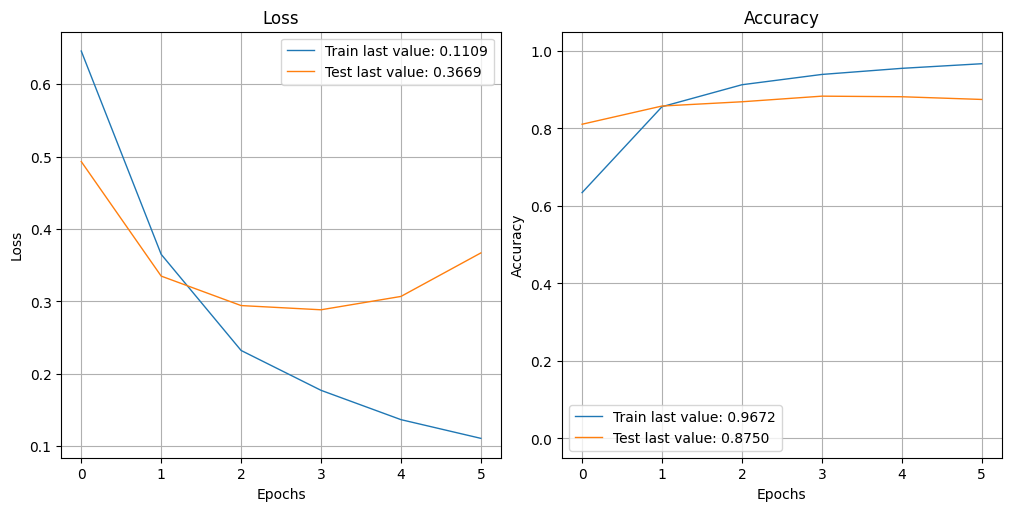

In [ ]:
plot_history(history.history, path="standard.png")
plt.show()

**Based on the accuracy plot, what do you think the optimal stopping point for your model should
have been?**

### **5. Evaluating the Model on the Test Data**

Evaluate the model on the padded test data using the code in the following cell block.

In [ ]:
# YOUR CODE TO EVALUATE THE MODEL ON TEST DATA GOES HERE
results = model.evaluate(padded_test_data, test_labels, batch_size=1000)
print('test_loss:', results[0], 'test_accuracy:', results[1])

25/25 [==============================] - 2s 91ms/step - loss: 0.3938 - accuracy: 0.8648
test_loss: 0.3937727212905884 test_accuracy: 0.864799976348877


###**6. Extracting the Word Embeddings**

Extract the word embeddings from the embedding layer model like we did in the last lab.

**Hints**

*  You can use model.get_layer(layer_name).get_weights()[0] or model.layers[layer_number].get_weights()[0].  The layer number indicates the order in which the layers were added to the model.

*  If you didn't explicitly name your layers, you can check layer names and numbers about the order from model.summary() or by calling model.layers

In [ ]:
# YOUR CODE GOES HERE
word_embeddings = model.get_layer("embedding").get_weights()[0]

In [ ]:
word_embeddings

array([[ 2.0989940e-02, -4.2546801e-03,  3.1474363e-03, ...,
         1.9765828e-02,  1.3848174e-02,  6.2694959e-04],
       [-1.4459278e-03, -1.1599002e-02,  7.7700643e-03, ...,
        -1.0048480e-02,  4.4481610e-03, -7.3845009e-03],
       [-1.6902514e-02,  2.0566165e-02, -2.0812545e-02, ...,
        -6.1655859e-03,  4.0935837e-03,  4.6519889e-03],
       ...,
       [-7.3965131e-03, -3.5823822e-02, -3.6472797e-03, ...,
        -3.4239896e-02,  5.7197397e-04, -4.2002386e-05],
       [-1.3272285e-02,  8.9626294e-03,  4.3662280e-02, ...,
         1.5245470e-02, -4.8954628e-02, -3.6760535e-02],
       [ 7.3570531e-04,  2.3773141e-02, -2.1385003e-03, ...,
        -6.7038187e-03,  1.6545057e-02, -9.5250132e-03]], dtype=float32)

***Sanity Check***

Print the shape of the word embeddings using the line of code below. It should return (VOCAB_SIZE, EMBED_SIZE)

In [ ]:
print('Shape of word_embeddings:', word_embeddings.shape)

Shape of word_embeddings: (10000, 100)


###**7. Visualizing the Reviews**

In this section, we will view the effects of padding the dataset.

As mentioned before, Keras already preprocessed the corpus. In this preprocessed corpus, all the words have already been mapped to indices and were assigned these numbers in order of their frequency such that index 2 is the 2nd most frequent word in the dataset, and so on. However, when we loaded our training dataset, we reserved the first 3 indices - 0, 1, 2 - for \<PAD\>, \<START\> and \<UNK\>. Additionally, we limited our vocabulary to only the top 10000 most frequent words (9997 if you exclude the padding). We will now visualize what a movie review will look like with these changes




**Step 1: Create a word2idx dictionary**

Create the word2idx dictionary using the following lines of code.

In [ ]:
# in this dictionary, the words start from 1, 0 is reserved for padding but
# <start> and <unknown> are not accounted for.
word_indices = imdb.get_word_index()

# so we shift each original word two places to make room for the two new tokens
offset = 2
word2idx = {k:(v+offset) for k,v in word_indices.items() if v < 9998}
word2idx["<PAD>"] = 0
word2idx["<START>"] = 1
word2idx["<UNK>"] = 2

1641221/1641221 [==============================] - 0s 0us/step



**Step 2: Create a the idx2word dictionary**

In [ ]:
# YOUR CODE GOES HERE
# YOUR CODE GOES HERE
offset = 2
idx2word = {(v+offset):k for k,v in word_indices.items() if v < 9998}
idx2word[0] = "<PAD>"
idx2word[1] = "<START>"
idx2word[2] = "<UNK>"


**Step 3: Visualize sample review**

View a sample review text using the lines of code below:

In [ ]:
print(' '.join(idx2word[idx] for idx in train_data[0]))

<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wha

###**8. Visualizing the Word_Embeddings**

Visualize the word embeddings for 10 of the words using pandas DataFrame like we did in lab 3

In [ ]:
from pandas import DataFrame

(DataFrame(word_embeddings, index=idx2word.values()).head(10))

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
woods,0.020990,-0.004255,0.003147,0.010062,-0.007641,0.018025,-0.004899,-0.005778,0.022412,0.002985,...,0.023715,0.010737,0.001706,-0.008559,-0.004401,0.019043,0.005723,0.019766,0.013848,0.000627
hanging,-0.001446,-0.011599,0.007770,-0.003841,-0.021825,0.005791,0.018481,0.015780,-0.020250,-0.010129,...,0.001389,0.016204,-0.013483,-0.017844,0.023773,0.007843,-0.012831,-0.010048,0.004448,-0.007385
woody,-0.016903,0.020566,-0.020813,0.000088,0.006057,0.006724,0.008022,0.014201,0.019444,0.011417,...,0.017045,0.021308,0.012796,0.009563,-0.012631,0.025710,-0.025182,-0.006166,0.004094,0.004652
arranged,-0.016508,0.005310,-0.007144,0.001153,0.013351,-0.025810,0.015766,-0.005823,0.006839,0.018644,...,0.012683,0.026708,0.014347,-0.026209,0.000160,-0.016585,0.005650,-0.003366,0.012311,-0.004410
bringing,-0.010211,0.000630,0.018111,0.022061,0.002173,-0.010650,-0.009783,0.007663,0.002266,-0.006959,...,-0.013254,0.030215,-0.009339,0.005797,-0.008565,0.006894,-0.007094,0.007009,-0.023883,0.035773
wooden,-0.002384,0.003992,0.014644,0.018903,-0.018643,-0.015513,-0.015309,0.003820,-0.002798,-0.009967,...,-0.001796,-0.002027,-0.009481,0.008962,-0.004199,0.032976,-0.004040,-0.028502,-0.013637,0.031085
errors,-0.021139,0.018646,0.003240,-0.017176,-0.012612,0.008822,-0.006484,0.005291,0.000529,-0.008003,...,-0.016763,-0.003868,0.000986,0.014124,0.015805,0.029256,-0.009515,-0.021147,-0.005368,-0.010505
dialogs,-0.018138,0.015465,-0.024625,-0.013808,0.015601,0.015792,0.014335,-0.020075,0.006157,0.015217,...,-0.015991,-0.004095,-0.021357,-0.006561,0.014257,-0.008996,0.014986,-0.000375,-0.016110,0.018401
kids,0.017292,0.011678,0.024815,0.009771,-0.017686,-0.039657,0.000469,0.005324,-0.001548,0.025843,...,0.017024,0.001875,0.002450,-0.027553,0.022208,0.006646,0.003928,0.000468,-0.001066,-0.007283
uplifting,-0.002426,-0.029647,-0.021197,0.003734,-0.018283,-0.005860,0.001463,-0.024629,-0.000590,0.006237,...,0.013661,-0.005769,-0.000184,0.018414,-0.013916,-0.028787,0.021589,0.014109,-0.011014,0.004451


###**9. Plot your Word Embeddings using t-SNE**


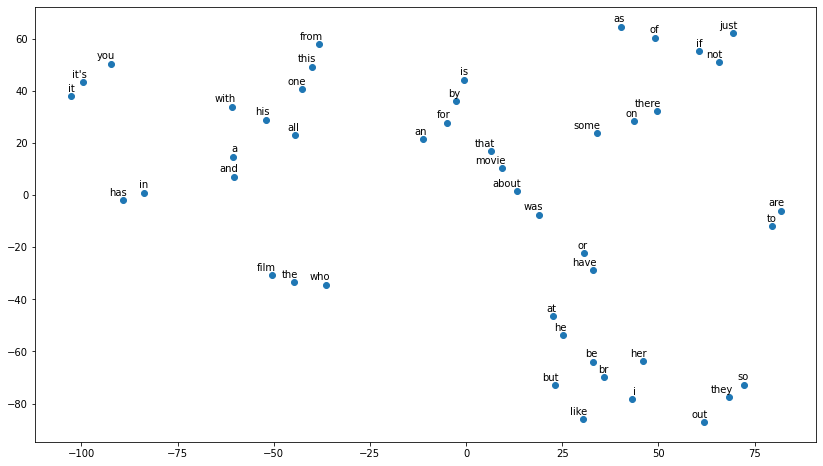

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import  numpy as np

tsne = TSNE(perplexity=3, n_components=2, init='pca', n_iter=5000, method='exact')
np.set_printoptions(suppress=True)
plot_only = 50

# don't plot the special tokens
start = 3
T = tsne.fit_transform(word_embeddings[start:plot_only, :])
labels = [idx2word[i] for i in range(start, plot_only)]
plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1])
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points', ha='right', va='bottom')


###**10. Questions**

1. Create a new model that is a copy of the model step 3. To this new model,add two dropout layers, one between the embedding layer and the LSTM layer and another between the LSTM layer and the output layer. Repeat steps 4 and 5 for this model. What do you observe?

2. Experiment with training the model with batch sizes of 1, 32, len(training_data). What do you observe?

3. (optional) Can you retrain with a Bidirectional LSTM instead of an LSTM? What do you observe about the Bi-LSTM model?


##### P1

Create a new model that is a copy of the model step 3. To this new model,add two dropout layers, one between the embedding layer and the LSTM layer and another between the LSTM layer and the output layer. Repeat steps 4 and 5 for this model. What do you observe?

In [ ]:
# Import the necessary Keras modules
from keras.layers import Input, Embedding, Dense, LSTM, Dropout
from keras.models import Model

# Define the hyperparameters
EMBED_SIZE = 100
MAX_LENGTH = 500
VOCAB_SIZE = 10000

# Define the input layer with shape (MAX_LENGTH,)
input_imdb = Input(shape=(MAX_LENGHT,))

# Define the embedding layer to map each word in the input sequence to a dense vector of dimension EMBED_SIZE
embedding_layer = Embedding(mask_zero=True,  # Set to True to mask out zero-padding in input sequences
                            input_length=MAX_LENGTH,  # The maximum length of the input sequence
                            input_dim=VOCAB_SIZE,  # The size of the vocabulary
                            output_dim=EMBED_SIZE,  # The dimensionality of the embedding vector
                            embeddings_initializer='glorot_uniform')(input_imdb)  # The method used to initialize the weights

# Apply dropout regularization to the embedding layer to prevent overfitting
dropout_layer_1 = Dropout(rate=0.2)(embedding_layer)

# Add an LSTM layer to the model to capture the temporal dependencies in the input sequence
lstm_layer = LSTM(EMBED_SIZE, return_sequences=False)(dropout_layer_1)

# Apply dropout regularization to the LSTM layer to prevent overfitting
dropout_layer_2 = Dropout(rate=0.2)(lstm_layer)

# Add a dense layer with a sigmoid activation function to generate the binary classification output
dense_layer = Dense(1, activation='sigmoid')(dropout_layer_2)

# Define the model with the input and output layers
model = Model(inputs=input_imdb, outputs=dense_layer)

# Compile the model with Adam optimizer and binary cross-entropy loss function
model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

# Print a summary of the model architecture
model.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 500)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 500, 100)          1000000   
                                                                 
 dropout (Dropout)           (None, 500, 100)          0         
                                                                 
 lstm_2 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 1,080,501
Trainable params: 1,080,501
Non-tra

In [ ]:
history = model.fit(train_x, train_y, epochs=6, batch_size=1000, validation_data=(validation_x, validation_y))

Epoch 1/6
23/23 [==============================] - 19s 658ms/step - loss: 0.6413 - accuracy: 0.6619 - val_loss: 0.4534 - val_accuracy: 0.8000
Epoch 2/6
23/23 [==============================] - 14s 601ms/step - loss: 0.3656 - accuracy: 0.8563 - val_loss: 0.3532 - val_accuracy: 0.8585
Epoch 3/6
23/23 [==============================] - 13s 583ms/step - loss: 0.2486 - accuracy: 0.9075 - val_loss: 0.2946 - val_accuracy: 0.8775
Epoch 4/6
23/23 [==============================] - 13s 565ms/step - loss: 0.1927 - accuracy: 0.9323 - val_loss: 0.2845 - val_accuracy: 0.8830
Epoch 5/6
23/23 [==============================] - 13s 566ms/step - loss: 0.1573 - accuracy: 0.9477 - val_loss: 0.2980 - val_accuracy: 0.8815
Epoch 6/6
23/23 [==============================] - 13s 563ms/step - loss: 0.1298 - accuracy: 0.9583 - val_loss: 0.3045 - val_accuracy: 0.8815


25/25 [==============================] - 2s 91ms/step - loss: 0.3282 - accuracy: 0.8700
test_loss: 0.32820555567741394 test_accuracy: 0.8700399994850159


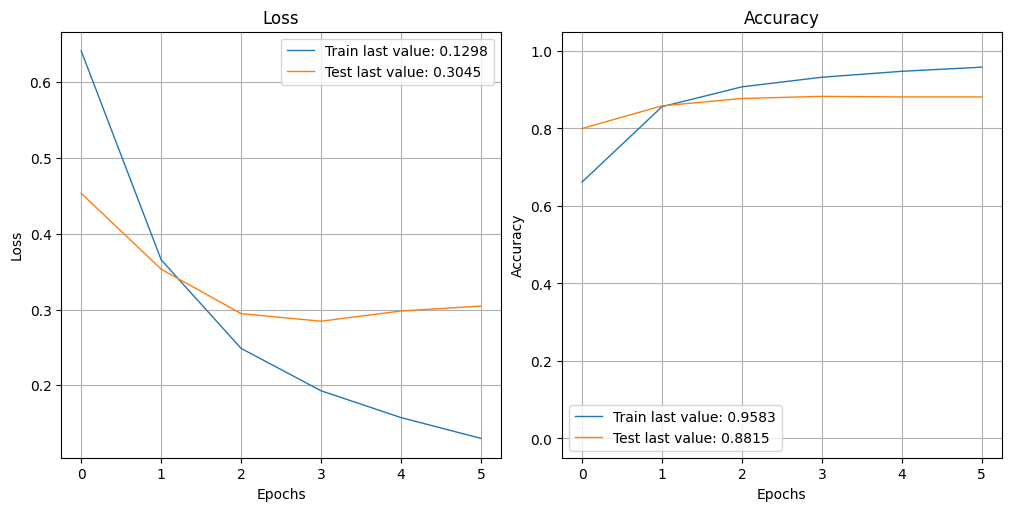

In [ ]:
results = model.evaluate(padded_test_data, test_labels, batch_size=1000)
print('test_loss:', results[0], 'test_accuracy:', results[1])

plot_history(history.history, path = "std.png")
plt.show()

In [ ]:
results = model.evaluate(padded_test_data, test_labels, batch_size=1000)
print('test_loss:', results[0], 'test_accuracy:', results[1])

25/25 [==============================] - 2s 90ms/step - loss: 0.3282 - accuracy: 0.8700
test_loss: 0.32820555567741394 test_accuracy: 0.8700399994850159


### P2
Experiment with training the model with batch sizes of 1, 32, len(training_data). What do you observe?

####  Batch size=1

In [ ]:
from keras.layers import Input, Embedding, Dense, LSTM, Dropout
from keras.models import Model

EMBED_SIZE = 100
MAX_LENGTH = 500
VOCAB_SIZE = 10000
input_imdb = Input(shape=(MAX_LENGHT,))
embedding_layer = Embedding(mask_zero = True,
                            input_length = MAX_LENGTH,
                            input_dim = VOCAB_SIZE,
                            output_dim = EMBED_SIZE,
                            embeddings_initializer='glorot_uniform')(input_imdb)
lstm_layer = LSTM(EMBED_SIZE, return_sequences = False)(embedding_layer)
dense_layer = Dense(1, activation = 'sigmoid')(lstm_layer)
model = Model(inputs= input_imdb, outputs=dense_layer)
model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 500)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 500, 100)          1000000   
                                                                 
 lstm_2 (LSTM)               (None, 100)               80400     
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 1,080,501
Trainable params: 1,080,501
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# BatchSize = 1
history = model.fit(train_x, train_y, epochs=6, batch_size=1, validation_data=(validation_x, validation_y))
plot_history(history.history, path="standard.png")
plt.show()
results = model.evaluate(padded_test_data, test_labels, batch_size=1000)
print('test_loss:', results[0], 'test_accuracy:', results[1])
# takes a lot of time

Epoch 1/6
   25/23000 [..............................] - ETA: 4:07:27 - loss: 0.6921 - accuracy: 0.6000

KeyboardInterrupt: ignored

##### Batch Size = 32

In [ ]:
# BatchSize = 32
EMBED_SIZE = 100
MAX_LENGTH = 500
VOCAB_SIZE = 10000
input_imdb = Input(shape=(MAX_LENGHT,))
embedding_layer = Embedding(mask_zero = True,
                            input_length = MAX_LENGTH,
                            input_dim = VOCAB_SIZE,
                            output_dim = EMBED_SIZE,
                            embeddings_initializer='glorot_uniform')(input_imdb)
lstm_layer = LSTM(EMBED_SIZE, return_sequences = False)(embedding_layer)
dense_layer = Dense(1, activation = 'sigmoid')(lstm_layer)
model = Model(inputs= input_imdb, outputs=dense_layer)
model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])


history = model.fit(train_x, train_y, epochs=6, batch_size=32, validation_data=(validation_x, validation_y))
plot_history(history.history, path="standard.png")
plt.show()
results = model.evaluate(padded_test_data, test_labels, batch_size=1000)
print('test_loss:', results[0], 'test_accuracy:', results[1])

Epoch 1/6
 83/719 [==>...........................] - ETA: 11:15 - loss: 0.6345 - accuracy: 0.6258

KeyboardInterrupt: ignored

##### Batch Size = len(training_data)

In [ ]:
# BatchSize = len(training_data)
EMBED_SIZE = 100
MAX_LENGTH = 500
VOCAB_SIZE = 10000
input_imdb = Input(shape=(MAX_LENGHT,))
embedding_layer = Embedding(mask_zero = True,
                            input_length = MAX_LENGTH,
                            input_dim = VOCAB_SIZE,
                            output_dim = EMBED_SIZE,
                            embeddings_initializer='glorot_uniform')(input_imdb)
lstm_layer = LSTM(EMBED_SIZE, return_sequences = False)(embedding_layer)
dense_layer = Dense(1, activation = 'sigmoid')(lstm_layer)
model = Model(inputs= input_imdb, outputs=dense_layer)
model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

history = model.fit(train_x, train_y, epochs=6, batch_size=len(train_x), validation_data=(validation_x, validation_y))
plot_history(history.history, path="standard.png")
plt.show()
results = model.evaluate(padded_test_data, test_labels, batch_size=1000)
print('test_loss:', results[0], 'test_accuracy:', results[1])

Epoch 1/6


ResourceExhaustedError: ignored